# Analyzing Crime in Vancouver
By: Ryan Saloff 32061624, Yash Mirani 78159415, Aditya Bakshi 28483832, Eva Ma 36961662

In [1]:
# Loads the packages used in the data analysis
library(IRdisplay)
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)
library(tidyverse)
library(datateachr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()   masks gridExtra::combine()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Introduction

The data set we are using is extracted from the PRIME BC Police Records Management System (RMS), regarding the instances of crime within Vancouver from 2003-2023. The columns describe the distinct types of crime, relating to the date/time, along with the specificities of the location in which the crime has occurred. This has enticed us to question: has the rate of theft and break/enter in Vancouver increased over the years? There is a positive correlation between crime and unemployment rates, as an increase in unemployment implicates an increase in acts of violence (Phillip et al., 2012). According to the graph attached below (StatCan, 2023), the average unemployment rate from 2004-2008 is 5.34%, while the rate from 2018-2022 is 6.2%. Phillip et al. (2012) state how we would expect that the crime rates to be higher given the unemployment rates throughout the years. On the other hand, Anderson et al., (2017) explain how crime rates in Vancouver should have reduced over time. Having two opposing implications, we investigate the crime rates of Vancouver to see which approach is supported by the given data. Crimes of theft, and break/enter are two indicators of crime that we will be focussing on, as they would correlate with unemployment, and thus be able to support our testing to answer our question regarding the crimes in Vancouver. 

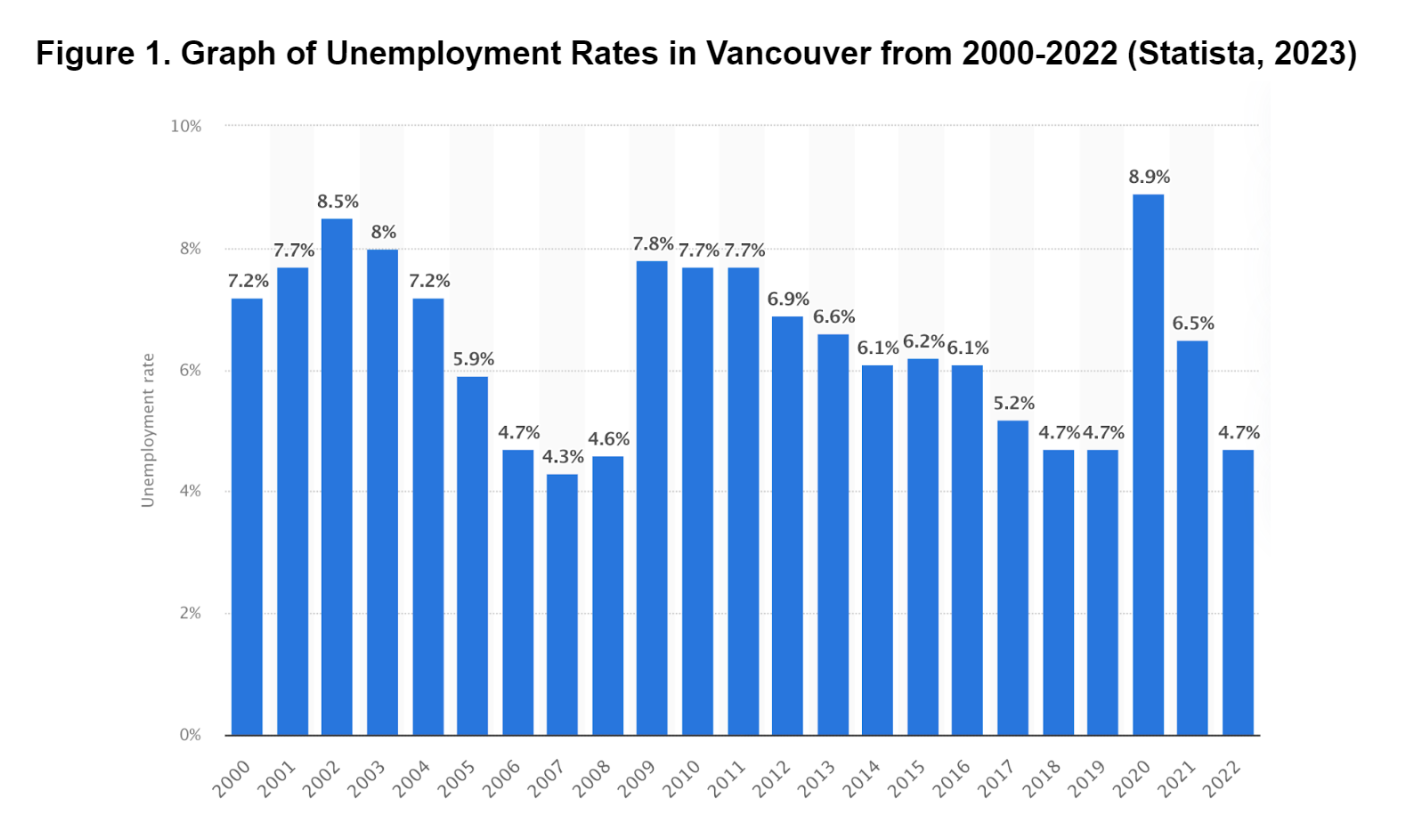

In [2]:
display_png(file = "Unemployment.png")

## Methods: Plan

The report utilizes data provided by the Vancouver Police Department, offering a reliable representation of crime statistics in Vancouver. Our objective is to study the proportion of thefts and break-ins relative to the total crimes, comparing time intervals of 2004-2008 and 2018-2022. Random sampling with sufficiently large sample sizes is used to ensure unbiased and representative point estimates, in order to be able to draw a conclusion towards the population.
However, summarizing our findings with plots and point estimates lack robust support for a hypothesis or a claim. To validate our hypothesis, we use hypothesis testing and a 95% confidence interval. We will use both bootstrapping and asymptotics models and compare them. This is possible because our sample size is large enough and np and nq are larger than 5. Additionally, calculating the confidence interval and conducting a hypothesis test reduces sample variation to ensure an accurate representation of the population. 
We will conduct 2 hypothesis tests using the infer() package and 2 two sample z-tests each regarding the difference in proportions to determine whether the proportion of break-ins and other thefts from 2018-2022 differs from those in 2004-2008. Our null hypothesis states that the proportion would remain the same, and our alternate hypothesis examines a decrease in crime proportions, as suggested by Anderson et al. (2017). We will additionally calculate a confidence interval using the estimation and bootstrapping method to determine whether the proportion of both these crimes from 2018-2022 differs from those in 2004-2008. The confidence interval assesses the difference in proportion of break-in proportions between the stated time periods, to evaluate claims by Anderson et al. (2017) against predictions by Phillip et al. (2012). 
Our report aids the Vancouver Police Department to optimally allocate resources by adjusting resources according to the crimes if proportions have increased or redirecting these to address more prevalent crimes. This analysis may raise future questions about the relationship between unemployment and theft, or identify vulnerable neighborhoods to theft. 


## Preliminary Results

#### Read Data from the Web

In [65]:
# Loads the dataset from the web
dataset <- read.csv(url("https://docs.google.com/spreadsheets/d/1SXkE_T-CmZzd1kPAIArQOLg9GQa_ftnmVMAI30sVDqo/export?gid=277724310&format=csv")) 

# Prints the first 6 rows of the dataset
table_1 <- "Table 1 - First Six Columns of the Dataset"
table_1
head(dataset)

# Prints the last 6 rows of the dataset
table_2 <- "Table 2 - Last Six Columns of the Dataset"
table_2
tail(dataset)

[1] "Table 1 - First Six Columns of the Dataset"

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2012,12,14,8,52,,Oakridge,491285.0,5453433
2,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
3,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
4,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
5,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
6,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


[1] "Table 2 - Last Six Columns of the Dataset"

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
877874,Vehicle Collision or Pedestrian Struck (with Injury),2023,2,22,12,12,YUKON ST / W BROADWAY AVE,Mount Pleasant,491786,5456719
877875,Vehicle Collision or Pedestrian Struck (with Injury),2003,9,1,20,45,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
877876,Vehicle Collision or Pedestrian Struck (with Injury),2005,7,20,18,57,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
877877,Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
877878,Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
877879,Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


#### Cleaning and Wrangling

In [66]:
# Removes the X and Y columns as well as inaccurate data
tidy_dataset <- dataset |>
    select(TYPE, YEAR) |>
    na.omit()

# Prints the first 6 rows of the dataset
table_3 <- "Table 3 - First Six Columns of the Tidy Dataset"
table_3
head(tidy_dataset)

# Prints the last 6 rows of the dataset
table_4 <- "Table 4 - Last Six Columns of the Tidy Dataset"
table_4
tail(tidy_dataset)

[1] "Table 3 - First Six Columns of the Tidy Dataset"

,TYPE,YEAR
,<chr>,<int>
1,Break and Enter Commercial,2012
2,Break and Enter Commercial,2019
3,Break and Enter Commercial,2019
4,Break and Enter Commercial,2021
5,Break and Enter Commercial,2014
6,Break and Enter Commercial,2020


[1] "Table 4 - Last Six Columns of the Tidy Dataset"

,TYPE,YEAR
,<chr>,<int>
877874,Vehicle Collision or Pedestrian Struck (with Injury),2023
877875,Vehicle Collision or Pedestrian Struck (with Injury),2003
877876,Vehicle Collision or Pedestrian Struck (with Injury),2005
877877,Vehicle Collision or Pedestrian Struck (with Injury),2016
877878,Vehicle Collision or Pedestrian Struck (with Injury),2013
877879,Vehicle Collision or Pedestrian Struck (with Injury),2013


#### Plotting the Raw Data

We will start by plotting the population data to visualize the number of other thefts and break and enters, out of the total number of crimes between 2004-2008 and 2018-2022.

In [67]:
# Filters the dataset for crimes during 2004 - 2008 and 2018 - 2022

raw_data <- tidy_dataset |>
    filter(YEAR %in% (2004:2008) | YEAR %in% (2018:2022)) |>
    group_by(TYPE, YEAR) |>
    summarize(n = n()) |>
    mutate(ranges = cut(YEAR, c(2004, 2008, 2017, 2022),
                        labels = c("[2004, 2008]","NA", "[2018, 2022]"), include.lowest = TRUE)) 

`summarise()` has grouped output by 'TYPE'. You can override using the
`.groups` argument.


In [68]:
# Calculates the sum of each crime

pop_1 = raw_data |>
    filter(ranges == "[2004, 2008]") |>
    summarize(n = sum(n))

# Number of crimes from 2004 - 2008
pop_1_total_crime = pop_1 |>
    summarize(n = sum(n)) |>
    as.numeric()

# Number of other thefts from 2004 - 2008
pop_1_other_thefts = pop_1 |>
    filter(TYPE == "Other Theft") |>
    summarize(n = sum(n)) |>
    as.numeric()

# Number of break and enters from 2004 - 2008
pop_1_bne = pop_1 |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    summarize(n = sum(n)) |>
    as.numeric()

pop_2 = raw_data |>
    filter(ranges == "[2018, 2022]") |>
    summarize(n = sum(n))

# Number of crimes from 2018 - 2022
pop_2_total_crime = pop_2 |>
    summarize(n = sum(n)) |>
    as.numeric()

# Number of other thefts from 2018 - 2022
pop_2_other_thefts = pop_2 |>
    filter(TYPE == "Other Theft") |>
    summarize(n = sum(n)) |>
    as.numeric()

# Number of break and enters from 2018 - 2022
pop_2_bne = pop_2 |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    summarize(n = sum(n)) |>
    as.numeric()

crimes <- c(pop_1_bne, pop_1_other_thefts, pop_1_total_crime, pop_2_bne, pop_2_other_thefts, pop_2_total_crime)

labels <- c("Break and Enters", "Other Thefts", "All Crimes","Break and Enters", "Other Thefts", "All Crimes")

years <- c("2004-2008","2004-2008","2004-2008","2018-2022","2018-2022","2018-2022")

# Creates the table of the number of crimes in each year
crimes_table <- tibble(labels, years, crimes)

comment(table) <- "Table 5 - Types of Crimes in Year Range"

comment(table)
crimes_table

[1] "Table 5 - Types of Crimes in Year Range"

labels,years,crimes
<chr>,<chr>,<dbl>
Break and Enters,2004-2008,40591
Other Thefts,2004-2008,52281
All Crimes,2004-2008,247250
Break and Enters,2018-2022,20861
Other Thefts,2018-2022,51555
All Crimes,2018-2022,196376


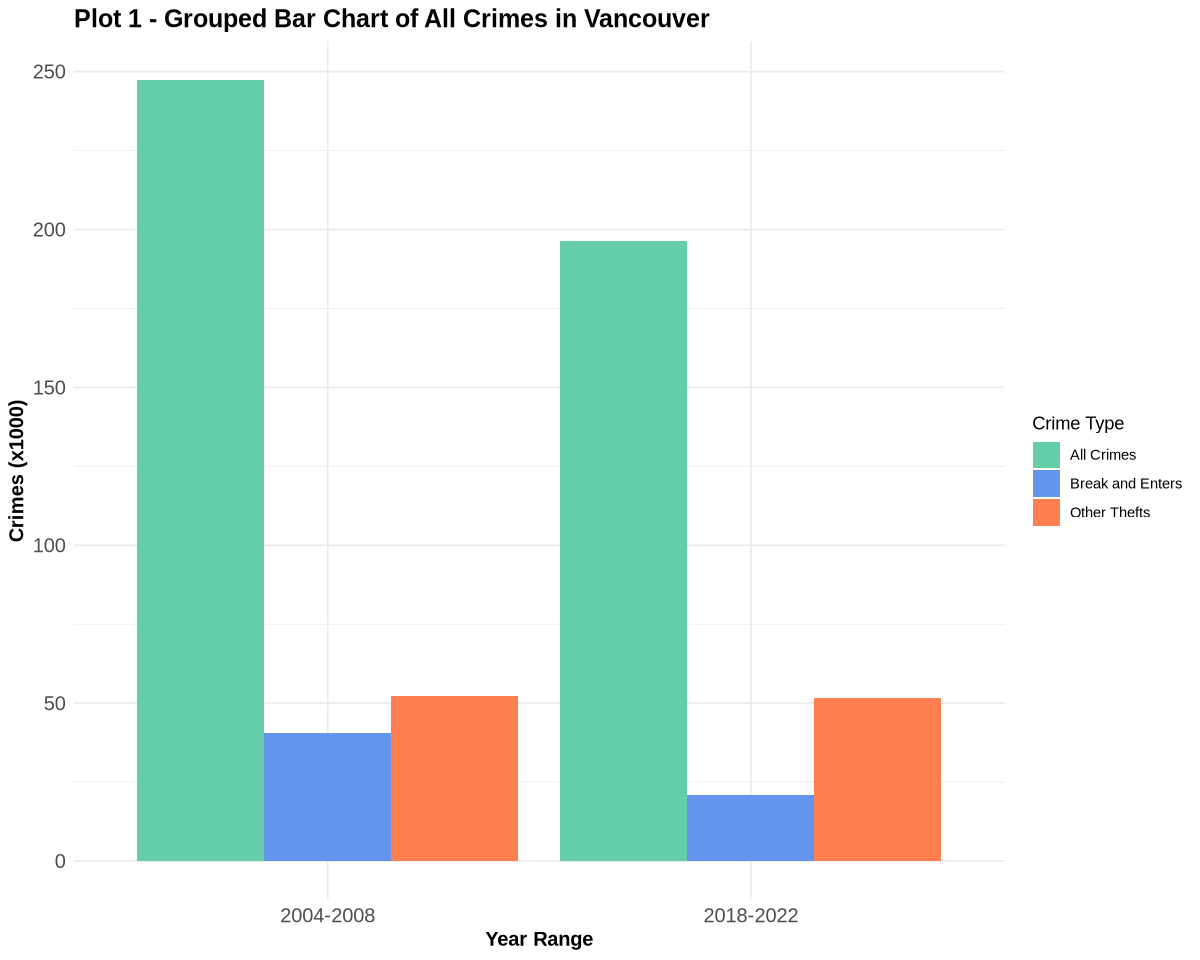

In [97]:
# Plots the number of crimes in each year
raw_data_plot <- crimes_table |>
    ggplot(aes(x = years, y = crimes/1000, fill = labels)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(title = "Plot 1 - Grouped Bar Chart of All Crimes in Vancouver",
    x = "Year Range",
    y = "Crimes (x1000)",
        fill = "Crime Type") +
    scale_fill_manual(values = c("All Crimes" = "aquamarine3", "Break and Enters" = "cornflower blue", "Other Thefts" = "coral")) +
    theme_minimal() +
    theme(axis.text=element_text(size=12),
        axis.title=element_text(size=12,face="bold"),
         plot.title = element_text(size = 15, face = "bold"))

raw_data_plot

Now, we will calculate the population parameters (difference of proportion of each type of crime out of all crimes) for the 2004-2008 and 2018-2022 year ranges. The population parameter will be used to evaluate the accuracy of our data analysis.

In [98]:
# Calculates and and creates the proportion difference vector
prop_diff <- c(crimes_table$crimes[4]/crimes_table$crimes[6] - crimes_table$crimes[1]/crimes_table$crimes[3],
          crimes_table$crimes[5]/crimes_table$crimes[6] - crimes_table$crimes[2]/crimes_table$crimes[3])

# Creates the crime type vector
crime <- c("Break and Enters","Other Thefts")

# Creates the table with each vector
pop_prop <- tibble(crime, prop_diff)

comment(pop_prop) <- "Table 6 - Difference of Proportion Parameter (2018-2022 Proportion minus 2004-2008 Proportion)"
comment(pop_prop)
pop_prop

[1] "Table 6 - Difference of Proportion Parameter (2018-2022 Proportion minus 2004-2008 Proportion)"

crime,prop_diff
<chr>,<dbl>
Break and Enters,-0.05793998
Other Thefts,0.05108213


#### Estimating the Parameter ####

In [99]:
# Filters the dataset for years 2004 - 2008 and selects the type of crime and the neighbourhood
crime_2004_2008 <- tidy_dataset |>
    filter(YEAR %in% (2004:2008)) |>
    select(TYPE)

# Prints the first 6 rows of the dataset
table_7 <- "Table 7 - All Crimes from 2004 - 2008"
table_7
head(crime_2004_2008)

[1] "Table 7 - All Crimes from 2004 - 2008"

,TYPE
,<chr>
1,Break and Enter Commercial
2,Break and Enter Commercial
3,Break and Enter Commercial
4,Break and Enter Commercial
5,Break and Enter Commercial
6,Break and Enter Commercial


In [100]:
set.seed(1)

# Randomly samples the 2004-2008 crime population (size = 500)
sample_2004_2008 <- crime_2004_2008 |>
    rep_sample_n(size = 500, replace = FALSE) |>
    ungroup() |>
    select(-replicate)

# Filters for "Other Theft" from the random sample
other_theft_2004_2008 <- sample_2004_2008 |>
    filter(TYPE == "Other Theft") 

# Calculates p̂ for other theft from 2004-2008
phat_theft_1 <- nrow(other_theft_2004_2008)/nrow(sample_2004_2008)

# Prints the other theft proportion estimate from 2004-2008
print(paste0("The estimated proportion of other theft crimes out of all crimes in Vancouver from 2004 - 2008 is ", phat_theft_1, "."))

# Filters for "Break and Enter Commercial" and "Break and Enter Residential/Other" from the random sample
break_and_enter_2004_2008 <- sample_2004_2008 |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") 

# Calculates p̂ for break and enters from 2004-2008
phat_bne_1 <- nrow(break_and_enter_2004_2008)/nrow(sample_2004_2008)

# Prints the break and enter proportion estimate from 2004-2008
print(paste0("The estimated proportion of break and enter crimes out of all crimes in Vancouver from 2004 - 2008 is ", phat_bne_1, "."))

[1] "The estimated proportion of other theft crimes out of all crimes in Vancouver from 2004 - 2008 is 0.21."
[1] "The estimated proportion of break and enter crimes out of all crimes in Vancouver from 2004 - 2008 is 0.196."


Now, we will find the sample proportions for the crimes of interest, between 2018 and 2022.

In [101]:
# Filters the dataset for years 2004 - 2008 and selects the type of crime and the neighbourhood
crime_2018_2022 <- tidy_dataset |>
    filter(YEAR %in% (2018:2022)) |>
    select(TYPE)

# Prints the first 6 rows of the dataset
table_8 <- "Table 8 - All Crimes from 2018 - 2022"
table_8
head(crime_2018_2022)

[1] "Table 8 - All Crimes from 2018 - 2022"

,TYPE
,<chr>
1,Break and Enter Commercial
2,Break and Enter Commercial
3,Break and Enter Commercial
4,Break and Enter Commercial
5,Break and Enter Commercial
6,Break and Enter Commercial


In [102]:
set.seed(2)

# Randomly samples the 2018-2022 crime population (size = 500)
sample_2018_2022 <- crime_2018_2022 |>
    rep_sample_n(size = 500, replace = FALSE) |>
    ungroup() |>
    select(-replicate)

# Filters for "Other Theft" from the random sample
other_theft_2018_2022 <- sample_2018_2022 |>
    filter(TYPE == "Other Theft") 

# Calculates p̂ for other theft from 2018-2022
phat_theft_2 <- nrow(other_theft_2018_2022)/nrow(sample_2018_2022)

# Prints the other theft proportion estimate from 2018-2022
print(paste0("The estimated proportion of other theft crimes out of all crimes in Vancouver from 2018 - 2022 is ", phat_theft_2, "."))

# Filters for "Break and Enter Commercial" and "Break and Enter Residential/Other" from the random sample
break_and_enter_2018_2022 <- sample_2018_2022 |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") 

# Calculates p̂ for break and enters from 2018-2022
phat_bne_2 <- nrow(break_and_enter_2018_2022)/nrow(sample_2018_2022)

# Prints the break and enter proportion estimate from 2018-2022
print(paste0("The estimated proportion of break and enter crimes out of all crimes in Vancouver from 2018 - 2022 is ", phat_bne_2, "."))

[1] "The estimated proportion of other theft crimes out of all crimes in Vancouver from 2018 - 2022 is 0.264."
[1] "The estimated proportion of break and enter crimes out of all crimes in Vancouver from 2018 - 2022 is 0.148."


Finally, we will calculate the difference in sample proportions—our sample statistic of interest.

In [103]:
# Calculates the difference in sample proportions for other theft
phat_theft = phat_theft_2 - phat_theft_1
print(paste0("The estimated difference in proportion of other theft crimes from 2018 - 2022 and 2004 - 2008 out of all crimes in Vancouver is ", phat_theft, "."))


# Calculates the difference in sample proportions for break and enters
phat_bne = phat_bne_2 - phat_bne_1
print(paste0("The estimated difference in proportion of break and enters from 2018 - 2022 and 2004 - 2008 out of all crimes in Vancouver is ", phat_bne, "."))

[1] "The estimated difference in proportion of other theft crimes from 2018 - 2022 and 2004 - 2008 out of all crimes in Vancouver is 0.054."
[1] "The estimated difference in proportion of break and enters from 2018 - 2022 and 2004 - 2008 out of all crimes in Vancouver is -0.048."


Now, we will visualize our statistic of interest in a table.

In [104]:
# Creates the vectors in the tbale
crime <- c("Other Theft", "Break and Enters")
p_hat <- c(phat_theft, phat_bne) 

# Creates the table
p_hat_table <- tibble(crime, p_hat)

comment(p_hat_table) <- "Table 9 - Difference in Estimated Proportion of Crimes from 2018 - 2022 and 2004 - 2008"

comment(p_hat_table)
p_hat_table 

[1] "Table 9 - Difference in Estimated Proportion of Crimes from 2018 - 2022 and 2004 - 2008"

crime,p_hat
<chr>,<dbl>
Other Theft,0.054
Break and Enters,-0.048


## Results

#### Other Thefts Hypothesis Testing

First, we will conduct a **permutation hypothesis test** for the difference of proportions of other thefts in our time interval of 2018-2022 versus 2004-2008. Then, we will conduct an **asymptotics test** through the **two sample z-test** for the difference of proportions of thefts in our time interval of 2018-2022 versus 2004-2008. We will be continuing to use `sample_2004_2008` and `sample_2018_2022` as our samples from the population dataset, where `n = 500` in each sample.

Our null hypothesis for the difference in proportion of other thefts is $H_0: p_{2018-2022} = p_{2004-2008}$

Our alternative hypothesis for the difference in proportion of other thefts is $H_A: p_{2018-2022} < p_{2004-2008}$

##### Permutation Hypothesis Test

In [105]:
# Creates the 2004-2008 sample dataframe with "year_range" and "theft" as columns
year <- data.frame(year_range = rep("2004-2008", times = 500))
theft <-ifelse(sample_2004_2008$TYPE == "Other Theft", "yes", "no")  
table_2004_2008 <- cbind(year, theft)

# Creates the 2018-2022 sample with "year_range" and "theft" as columns
year <- data.frame(year_range = rep("2018-2022", times = 500))
theft <-ifelse(sample_2018_2022$TYPE == "Other Theft", "yes", "no")
table_2018_2022 <- cbind(year, theft)

# Combines the 2004-2008 and 2018-2022 datasets 
thefts_table <- rbind(table_2004_2008, table_2018_2022) 

table_10 <- "Table 10 - Thefts in Both Samples (yes = theft)"

# Print the transformed table
table_10
head(thefts_table)

[1] "Table 10 - Thefts in Both Samples (yes = theft)"

,year_range,theft
,<chr>,<chr>
1,2004-2008,no
2,2004-2008,no
3,2004-2008,yes
4,2004-2008,no
5,2004-2008,no
6,2004-2008,no


In [106]:
# Calculates the null distribution using the infer package workflow
thefts_null_distribution <- thefts_table |>
    specify(formula = theft ~ year_range, success = "yes") |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in props", order = c("2018-2022","2004-2008"))

table_11 <- "Table 11 - Null Distribution of the Difference in Proportion of Thefts (2018-2022 – 2004-2008)"

# Prints the null distribution
table_11
head(thefts_null_distribution)

[1] "Table 11 - Null Distribution of the Difference in Proportion of Thefts (2018-2022 – 2004-2008)"

replicate,stat
<int>,<dbl>
1,-0.014
2,0.026
3,-0.042
4,0.030
5,0.014
6,-0.014


Now, we will visualize our sample statistic of the difference of proportions $\hat{p}_{theft} = 0.054$ in respect to the null distribution.

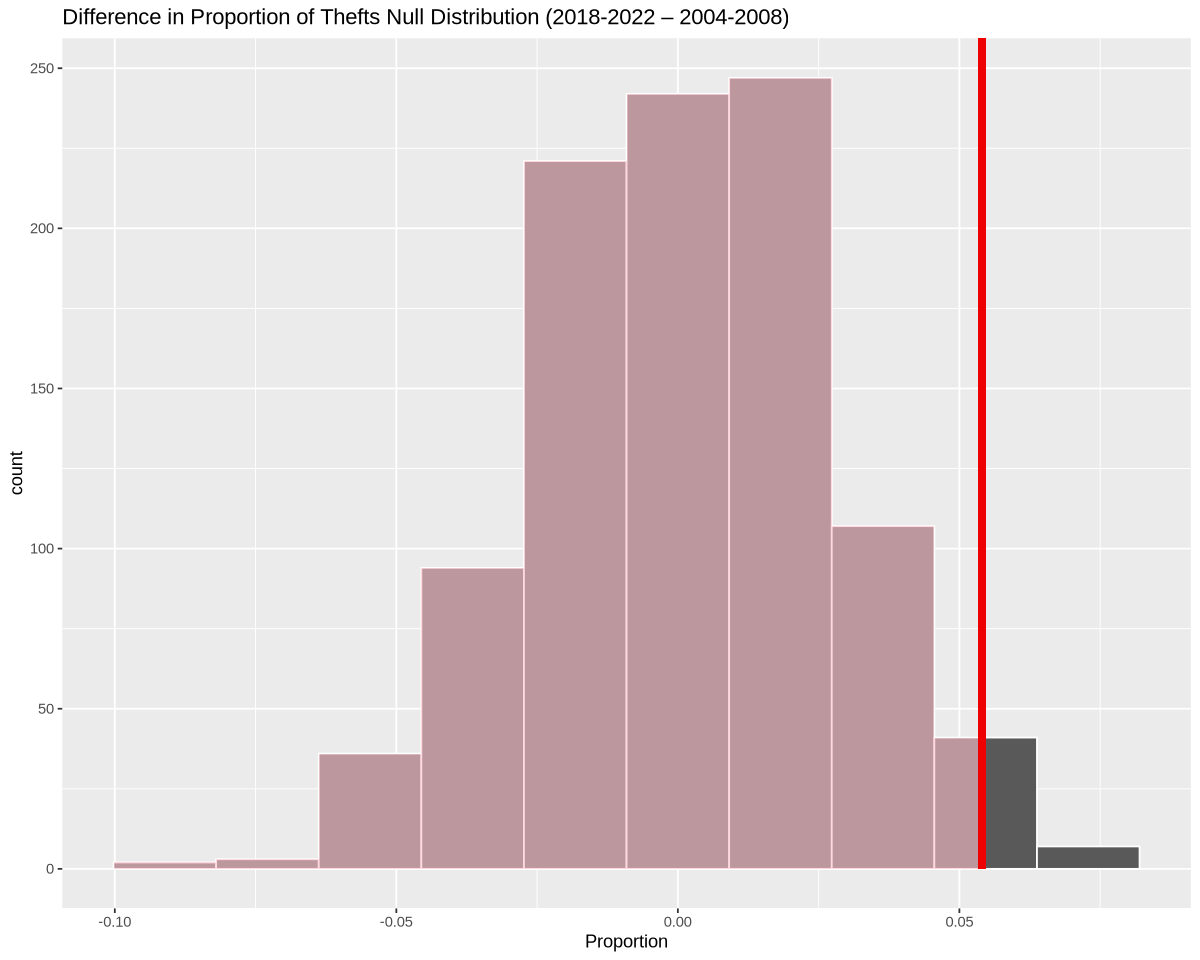

In [107]:
# Plots the null distribution
thefts_result_plot <- thefts_null_distribution |>
    visualize(bins = 10) +
    shade_p_value(obs_stat = phat_theft, direction = "left") +
    labs(x = "Proportion", title = "Difference in Proportion of Thefts Null Distribution (2018-2022 – 2004-2008)") 
    

thefts_result_plot

In [108]:
# Gets the p-value for the difference of proportions (2018-2022 - 2008-2004) in thefts
thefts_p_value <- thefts_null_distribution |>
    get_p_value(obs_stat = phat_theft, direction = "left") |>
    pull() 

cat("The p-value is for the permutation test is:", thefts_p_value)

The p-value is for the permutation test is: 0.982

Given a p-value of $0.982$, we fail to reject the null hypothesis at the $5\%$ significance level for the permutation test.

##### Two Sample Z-test 

In [109]:
# Makes a new table that can be used by the prop.test function
new_table_thefts <- table(thefts_table$year_range, thefts_table$theft)

# Perform the two-sample z-test
result_thefts <- prop.test(new_table_thefts, alternative = "less")

# Gets the two_sample z-test p_value
p_value_thefts_ztest <- result_thefts$p.value

# Print the result
cat("The p_value for the two_sample z-test is:", p_value_thefts_ztest)

The p_value for the two_sample z-test is: 0.9734107

Given a p-value $\approx 0.973$, we fail to reject the null hypothesis at the $5\%$ significance level for the two-sample z test.

#### Thefts Confidence Interval

First, we will create a bootstrap distribution confidence interval for the difference of proportions of thefts in our time interval of 2018-2022 versus 2004-2008. Then, we will create a theory-based standard error confidence interval for the difference of proportions of thefts in our time interval of 2018-2022 versus 2004-2008.

##### Bootstrap Distribution Confidence Interval

In [125]:
#Bootstrap distribution of the difference in the proportion of 'Other Thefts' between 2018-2022 and 2004-2008 

bootstrap_distribution <- thefts_table %>% 
  specify(formula = theft ~ year_range, success = "yes") %>% 
  generate(reps = 1000, type = "bootstrap") %>% 
  calculate(stat = "diff in props", order = c("2018-2022", "2004-2008"))

table_12 <- "Table 12 - Difference in proportion of Other Thefts in each bootstrap sample"

head(table_12)
head(bootstrap_distribution)

[1] "Table 12 - Difference in proportion of Other Thefts in each bootstrap sample"

replicate,stat
<int>,<dbl>
1,0.07134712
2,0.04764879
3,0.08870641
4,0.09001744
5,0.05953358
6,0.01596902


In [126]:
# Bootstrap distribution of the difference in the proportion of 'Other Thefts' between 2018-2022 and 2004-2008 

bootstrap_distribution <- thefts_table %>% 
  specify(formula = theft ~ year_range, success = "yes") %>% 
  generate(reps = 1000, type = "bootstrap") %>% 
  calculate(stat = "diff in props", order = c("2018-2022", "2004-2008"))

table_13 <- "Table 13 - Difference in Proportion of Other Thefts in each Bootstrap Sample"

head(table_13)
head(bootstrap_distribution)

[1] "Table 13 - Difference in Proportion of Other Thefts in each Bootstrap Sample"

replicate,stat
<int>,<dbl>
1,0.01202832
2,0.04882206
3,0.07593894
4,0.07317063
5,0.09737972
6,0.07465180


Now that we have generated our bootstrap samples and calculated the difference in proportion statistic, we will create the 95% Confidence Interval for the difference in proportion of Other Thefts.

In [128]:
# Constructs a 95% confidence interval based on percentile-method over the bootstrap distribution 
percentile_ci <- bootstrap_distribution %>% 
  get_confidence_interval(level = 0.95, type = "percentile")

table_14 <- "Table 14 - 95% Confidence Interval for Difference in Other Thefts using Bootstrap Percentile Method"

head(table_14)
percentile_ci

[1] "Table 14 - 95% Confidence Interval for Difference in Other Thefts using Bootstrap Percentile Method"

lower_ci,upper_ci
<dbl>,<dbl>
0.002260046,0.1013095


Finally, we can visualize the 95% confidence interval.

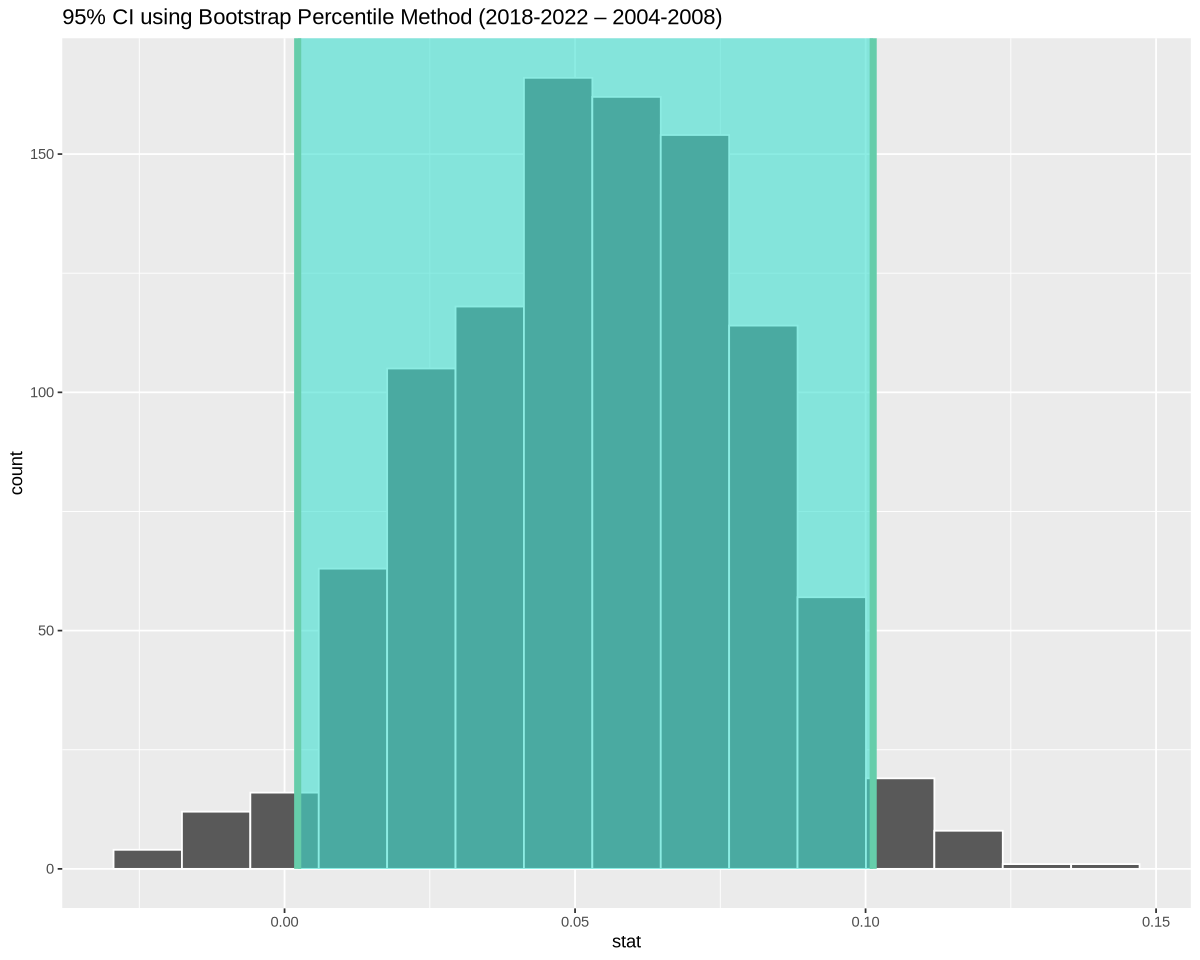

In [129]:
# Visualizes the 95% confidence interval constructed above
visualize(bootstrap_distribution) + 
    shade_confidence_interval(endpoints = percentile_ci) +
    labs(title = "95% CI using Bootstrap Percentile Method (2018-2022 – 2004-2008)")

As a reminder, our alternative hypothesis stated that $p_{2018-2022} < p_{2004-2008}$. As we can see, the $2004-2008$ proportion of Other Thefts is quite a bit bigger than the $2018-2022$ proportion of other thefts. In other words, we **fail to reject the null hypothesis**, since the confidence interval captures values greater than what we had expected. 

##### Theory-Based Standard Error Confidence Interval

Since our sample size is greater than 30, wherein our sample distribution is approximately normal and each observation is independent, we can use theory based methods for generating a confidence interval.

[1] "Table 15 - Confidence Interval for Difference in Proportion of Other Thefts using Standard Error Method"

lower_ci,upper_ci
<dbl>,<dbl>
0.002386946,0.1056131


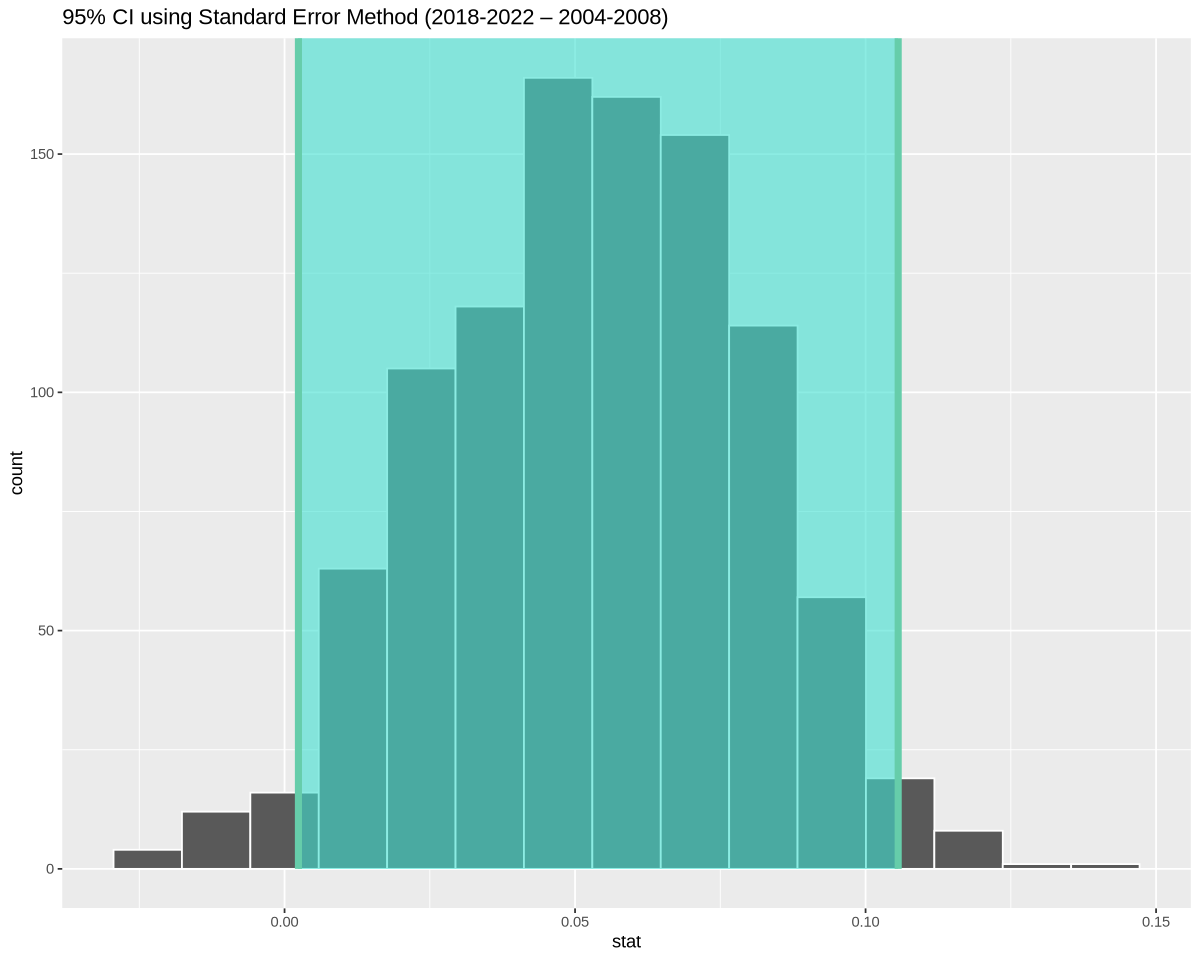

In [130]:
# Constructs a 95% confidence interval using the theory-based standard error method around the observed sample statistic of 'Other Thefts'
percentile_ci_theory <- bootstrap_distribution %>% 
  get_confidence_interval(level = 0.95, type = "se", point_estimate = 0.054)

table_15 <- "Table 15 - Confidence Interval for Difference in Proportion of Other Thefts using Standard Error Method"

head(table_15)
percentile_ci_theory

# Visualizes the 95% confidence interval constructed above 
visualize(bootstrap_distribution) + 
    shade_confidence_interval(endpoints = percentile_ci_theory) +
    labs(title = "95% CI using Standard Error Method (2018-2022 – 2004-2008)")

Similarly to the bootstrapping confidence interval, we **fail to reject the null hypothesis**, since the confidence interval captures values greater than what we had expected. 

#### Break and Enters Hypothesis Testing

We will first conduct a **permutation hypothesis test** for the difference of proportions of break and enters in our time interval of 2018-2022 versus 2004-2008. Then, we will conduct an **asymptotics test** through the **two sample z-test** for the difference of proportions of break and enters in our time interval of 2018-2022 versus 2004-2008. We will be continuing to use `sample_2004_2008` and `sample_2018_2022` as our samples from the population dataset, where `n = 500` in each sample.

Our null hypothesis for the difference in proportion of break and enters is $H_0: p_{2018-2022} = p_{2004-2008}$

Our alternative hypothesis for the difference in proportion of break and enters is $H_A: p_{2018-2022} < p_{2004-2008}$

In [115]:
# Prints a table that displays how many crimes in the sample were thefts

year <- data.frame(year_range = rep("2004-2008", times = 500))
theft <-ifelse(sample_2004_2008$TYPE == "Break and Enter Commercial" |
               sample_2004_2008$TYPE == "Break and Enter Residential/Other", "yes", "no")  
table_2004_2008_bne <- cbind(year, theft)

year <- data.frame(year_range = rep("2018-2022", times = 500))
theft <-ifelse(sample_2018_2022$TYPE == "Break and Enter Commercial" |
               sample_2018_2022$TYPE == "Break and Enter Residential/Other", "yes", "no")
table_2018_2022_bne <- cbind(year, theft)

bne_table <- rbind(table_2004_2008_bne, table_2018_2022_bne) 

table_16 <- "Table 16 - Break and Enters in Both Samples (yes = theft)"

# Print the transformed table
table_16
head(bne_table)

[1] "Table 16 - Break and Enters in Both Samples (yes = theft)"

,year_range,theft
,<chr>,<chr>
1,2004-2008,yes
2,2004-2008,no
3,2004-2008,no
4,2004-2008,no
5,2004-2008,no
6,2004-2008,no


In [116]:
# Calculates the null distribution using the infer package workflow
bne_null_distribution <- bne_table |>
    specify(formula = theft ~ year_range, success = "yes") |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in props", order = c("2018-2022","2004-2008"))

table_17 <- "Table 17 - Null Distribution of the Difference in Proportion of Break and Enters (2018-2022 – 2004-2008)"

# Prints the null distribution
table_17
head(bne_null_distribution)

[1] "Table 17 - Null Distribution of the Difference in Proportion of Break and Enters (2018-2022 – 2004-2008)"

replicate,stat
<int>,<dbl>
1,0.000
2,0.000
3,-0.016
4,-0.004
5,-0.024
6,0.032


Now, we will visualize our sample statistic of the difference of proportions $\hat{p}_{bne} = 	-0.048$ in respect to the null distribution.

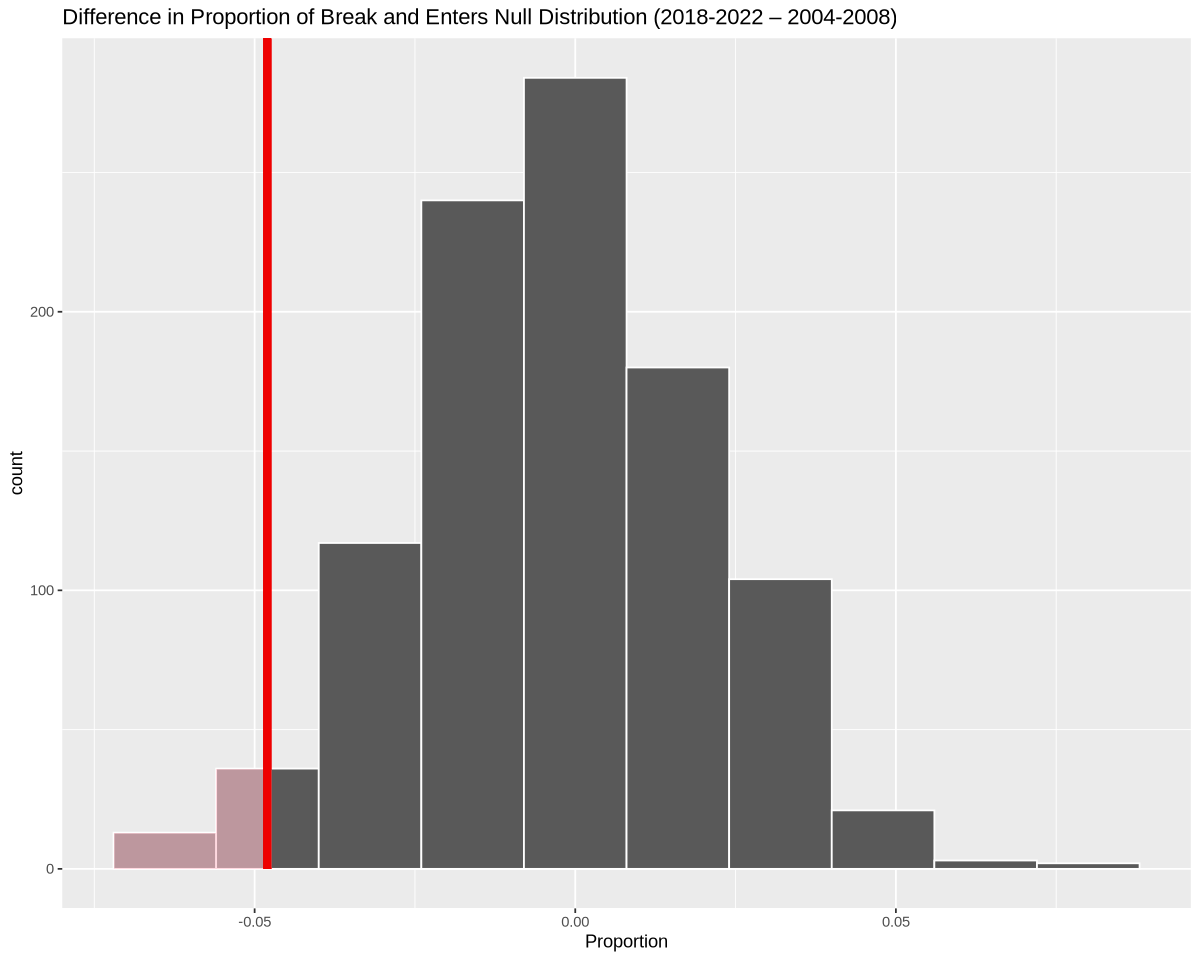

In [117]:
# Plots the null distribution
bne_result_plot <- bne_null_distribution |>
    visualize(bins = 10) +
    shade_p_value(obs_stat = phat_bne, direction = "left") +
    labs(x = "Proportion", title = "Difference in Proportion of Break and Enters Null Distribution (2018-2022 – 2004-2008)") 
    options(repr.plot.width=10, repr.plot.height=8)
    

bne_result_plot

In [118]:
# Gets the p-value for the difference of proportions (2018-2022 - 2008-2004) in break and enters
bne_p_value <- thefts_null_distribution |>
    get_p_value(obs_stat = phat_bne, direction = "left") |>
    pull() 

cat("The p-value is for the permutation test is:", bne_p_value)

The p-value is for the permutation test is: 0.031

Given a p-value of $0.031$, we reject the null hypothesis at the $5\%$ significance level for the permutation test.

##### Two Sample Z-test 

In [119]:
# Makes a new table that can be used by the prop.test function
new_bne_table <- table(bne_table$year_range, bne_table$theft)

# Perform the two-sample z-test
result_bne <- prop.test(new_bne_table, alternative = "less")

# Gets the two_sample z-test p_value
p_value_bne_ztest <- result_bne$p.value

# Print the result
cat("The p_value for the two_sample z-test is:", p_value_bne_ztest)

The p_value for the two_sample z-test is: 0.02697137

Given a p-value $\approx 0.027$, we reject the null hypothesis at the $5\%$ significance level for the two-sample z test.

#### Break and Enters Confidence Interval

##### Bootstrap Distribution Confidence Interval

First, we will create a bootstrap distribution confidence interval for the difference of proportions of thefts in our time interval of 2018-2022 versus 2004-2008. Then, we will create a theory-based standard error confidence interval for the difference of proportions of thefts in our time interval of 2018-2022 versus 2004-2008.

In [120]:
# Bootstrap distribution of the difference in the proportion of 'Break and Enters' between 2018-2022 and 2004-2008
bootstrap_distribution_bne <- bne_table %>% 
  specify(formula = theft ~ year_range, success = "yes") %>% 
  generate(reps = 1000, type = "bootstrap") %>% 
  calculate(stat = "diff in props", order = c("2018-2022", "2004-2008"))


table_18 <- "Table 18 - Difference in proportion of Break and Enters in each bootstrap sample"

head(table_18)
head(bootstrap_distribution_bne)

[1] "Table 18 - Difference in proportion of Break and Enters in each bootstrap sample"

replicate,stat
<int>,<dbl>
1,-0.06170468
2,-0.01041667
3,-0.01137821
4,-0.01451084
5,-0.05418595
6,-0.02464332


In [121]:
# Bootstrap distribution of the difference in the proportion of 'Break and Enters' between 2018-2022 and 2004-2008
bootstrap_distribution_bne <- bne_table %>% 
  specify(formula = theft ~ year_range, success = "yes") %>% 
  generate(reps = 1000, type = "bootstrap") %>% 
  calculate(stat = "diff in props", order = c("2018-2022", "2004-2008"))

table_19 <- "Table 19 - Difference in proportion of Break and Enters in each Bootstrap Sample"

head(table_17)
head(bootstrap_distribution_bne)

[1] "Table 17 - Null Distribution of the Difference in Proportion of Break and Enters (2018-2022 – 2004-2008)"

replicate,stat
<int>,<dbl>
1,-0.01932924
2,-0.01074804
3,-0.04462016
4,-0.05044491
5,-0.05924761
6,-0.04732019


Now that we have generated our bootstrap samples and calculated the difference in proportion statistic, we will create the 95% Confidence Interval for the difference in proportion of Break and Enters.

In [122]:
#Constructs a 95% confidence interval based on percentile-method over the bootstrap distribution
percentile_ci <- bootstrap_distribution_bne %>% 
  get_confidence_interval(level = 0.95, type = "percentile")

table_20 <- "Table 20 - Confidence Interval for Difference in Break and Enters using Bootstrap Percentile Method"

head(table_20) 
percentile_ci

[1] "Table 20 - Confidence Interval for Difference in Break and Enters using Bootstrap Percentile Method"

lower_ci,upper_ci
<dbl>,<dbl>
-0.09080803,-0.003792434


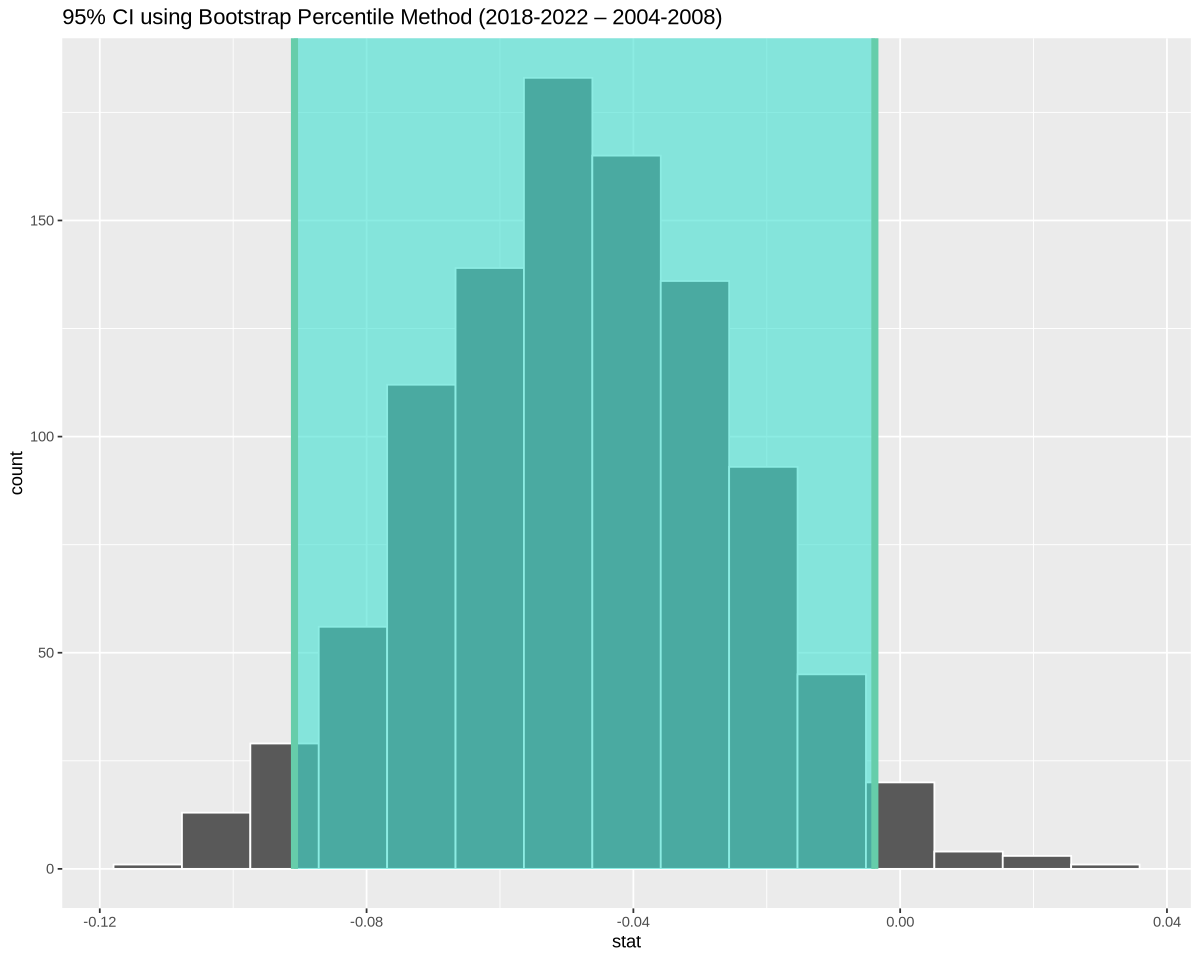

In [123]:
#Visualizes the 95% confidence interval constructed above
visualize(bootstrap_distribution_bne) + 
     shade_confidence_interval(endpoints = percentile_ci) +
     labs(title = "95% CI using Bootstrap Percentile Method (2018-2022 – 2004-2008)")

Similarly to the bootstrapping confidence interval, we **reject the null hypothesis**, since the confidence interval captures values less than no difference in proportions.

##### Theory-Based Standard Error Confidence Interval

Since our sample size is greater than 30, wherein our sample distribution is approximately normal and each observation is independent, we can use theory based methods for generating a confidence interval.

[1] "Table 21 - Confidence interval for difference in proportion of Break and Enters using theory-based standard error method"

lower_ci,upper_ci
<dbl>,<dbl>
-0.09236965,-0.003630347


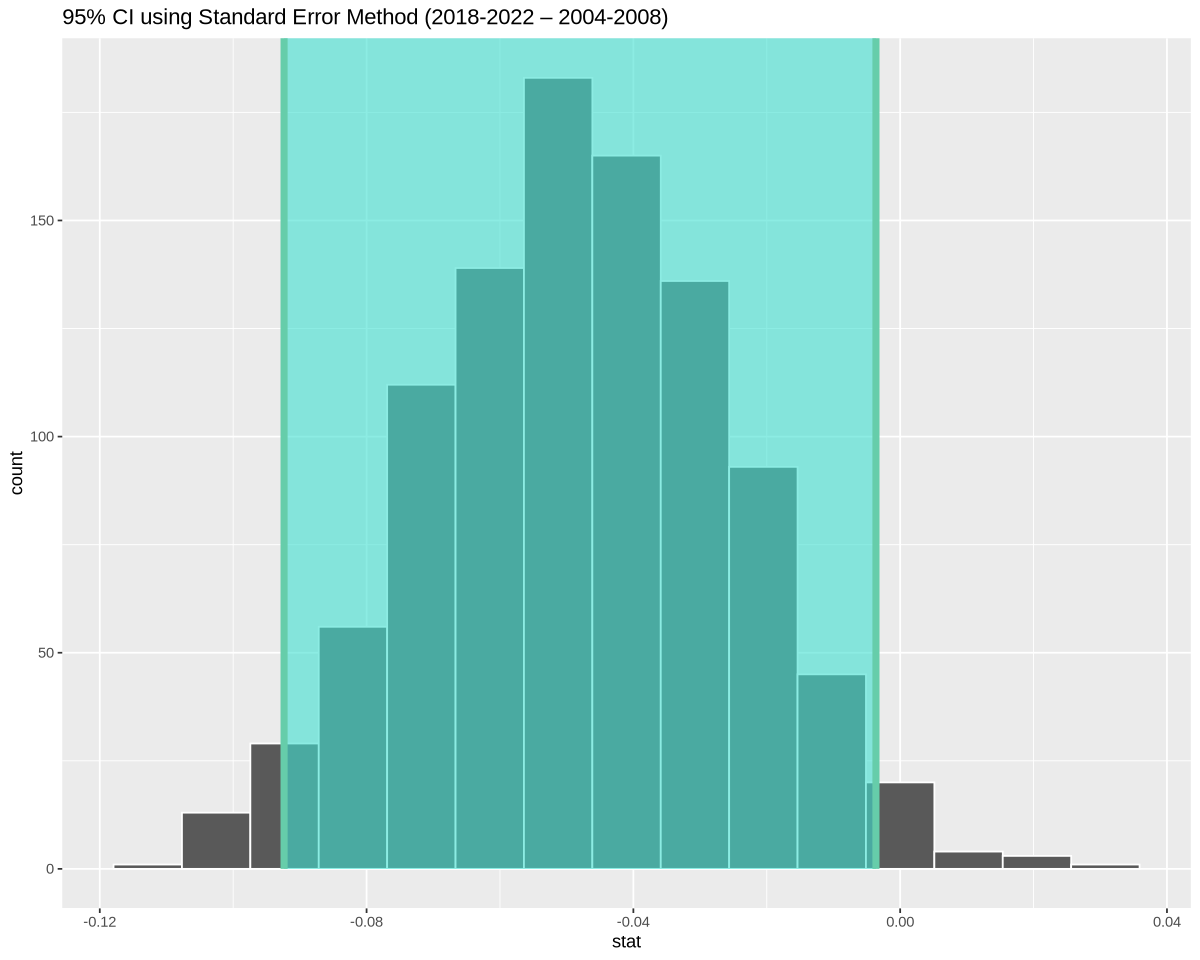

In [124]:
#Constructs a 95% confidence interval using the theory-based standard error method around the observed sample statistic of 'Break and Enters'
percentile_ci_theory_bne <- bootstrap_distribution_bne %>% 
  get_confidence_interval(level = 0.95, type = "se", point_estimate = -0.048)

table_21 <- "Table 21 - Confidence interval for difference in proportion of Break and Enters using theory-based standard error method"

head(table_21)
percentile_ci_theory_bne

#Visualizes the 95% confidence interval constructed above
visualize(bootstrap_distribution_bne) + 
    shade_confidence_interval(endpoints = percentile_ci_theory_bne) +
    labs(title = "95% CI using Standard Error Method (2018-2022 – 2004-2008)")

In contrast to the bootstrapping confidence interval, we **fail to reject the null hypothesis**, since the confidence interval captures the value of $0$. We do not have sufficient evidence to reject the null hypothesis.

## Discussion

### Summarize what you found, and the implications/impact of your findings.
In manipulating the raw data, we were initially able to visualize the number of “Other Thefts” and “Break and Enters” as seen in Plot 1. The population parameters were calculated from the raw data, specifically the difference in proportions of each crime type among all crimes, for the periods of 2004-2008 and 2018-2022. The proportion difference of recent years subtracted by previous years in Break and Enters is -0.058, while the difference in Other Thefts obtained a parameter value of 0.051. 

Random samples of size 500 from the 2004-2008 crime population were taken without replacement, in order to test our alternative hypothesis stating that the proportion of Break and Enters and Other Thefts would decrease over the years. This is done by calculating the sample proportion of Other Thefts in the time range of 2004-2008, and from 2018-2022; this identical process will be conducted for Break and Enters. From the sample, it was found that the estimated proportion of Other Theft crimes in Vancouver from 2004-2008 is 0.21, while the proportion in 2018-2022 was 0.264. On the other hand, the estimated proportion of Break and Enters was 0.196 and 0.148, respectively. 
By taking the difference in these proportions, we were able to obtain the difference in proportions within these timestamps, with a value of 0.054 for Other Thefts and -0.048 for Break and Enters. 

Through hypothesis testing via the infer() package using a bootstrapping distribution, the obtained p-value for the difference in proportions of Other Thefts is 0.973, while the p-value for Break and Enters is 0.027. To reiterate, our null hypothesis states that there would be no change in the difference in proportions from 2018-2022 and 2004-2008 for theft and break and enters. Alternatively, our Ha conveys that we would expect to observe a decrease in the difference in proportions  from 2018-2022 and 2004-2008 for theft and break and enters. At a significance level of 0.05, we are not able to acquire the evidence needed to reject the null hypothesis regarding Other Theft in Vancouver. P-value is the probability of observing the test statistic if the null hypothesis, while alpha is the significance level that has been previously set in our statistical examination. As our p-value of 0.973 is larger than alpha, this suggests that our data is not statistically significant; we fail to reject the null hypothesis, concluding that Other Theft in Vancouver has not changed over the time intervals from 2004-2008 and 2018-2022. Contrastingly, we are able to reject the null hypothesis regarding Break and Enter crime rates in Vancouver at a significance level of 0.05. Since the p-value is less than alpha, we reject the null hypothesis in favor of the alternative hypothesis, suggesting that our observed data is statistically significant and that there has been a decrease in Break and Enter crime rates in Vancouver (additionally supporting to the statement made by Anderson et al., (2017)). 

A series of confidence interval tests were proceeded, to further test our hypotheses. Confidence intervals at a 95% level for the proportional difference in Other Thefts via the bootstrapping percentile method of 1000 reps attained a value of [0.000189,0.105879]. On the other hand, the confidence interval values for the proportional difference in Break and Enters were [-0.083635,-0.007837]. Furthermore, confidence interval testings were conducted through standard error estimates at a 95% confidence interval for the proportional difference in the stated crimes as well; the confidence interval obtained from Other Thefts is [0.001842, 0.106158], and [-0.085851, -0.010149] for Break and Enters. By comparing the two intervals acquired for the two examined types of crime, we are able to note the differences in width in using the estimates or bootstrapping methods. As seen above, the confidence intervals obtained from the bootstrapping distribution was more narrow in comparison to that acquired from a standard error estimate; this may be due to how standard errors often rely on assumptions based on the distribution of the data, and if these assumptions are not entirely satisfied, the resulting interval may be wider to account for any variability. 

Both the bootstrapping and theory based confidence intervals suggest that theft has increased between the two time frames, while Break and Enters have reduced. This is because the theft confidence intervals are above 0 while the Break and Enters are below 0. This conclusion can be reached.as we are 95% confident that the difference in proportion of Break and Enter crime rates in Vancouver between the two time frames falls between [-0.083635,-0.007837]. Additionally, we are 95% confident that the difference in proportion of Other theft crime rates in Vancouver between the two time frames falls between [0.000189,0.105879]. 

Given the observed data stated above, we are able to compare the findings from Phillips et al. (2012) and Anderson et al. (2017). We anticipated that the crime rates in Vancouver would decrease over time in alignment with Anderson et al. (2017). In our analysis, we were unable to reject the hypothesis regarding Other Thefts, but we were able to conclude that the Break and Enter crime rates have decreased in the span of 20 years in Vancouver. This draws implications towards the development of technology, such as Geospatial technology that refers to the ability to assess crime based on its location and prediction with a high accuracy (Azmy et al., 2020). As the future approaches and technology begins to advance, many households and workplaces will be equipped with more protective security systems such as CCTV cameras in hopes of deterring crime and providing faster crime resolution. Additionally, geospatial technology is quickly advancing as the forms in which crime data is analyzed is enhanced over time to help law enforcement predict and prevent crimes from occurring by identifying patterns and trends in criminal behavior within a location. This supports the trend that was hypothesized by Anderson et al. (2017), stating that there are decreases in certain crime types in particular areas in Vancouver; the reason we would expect that crime rates (such as Break and Enter) decrease could be due to the fact that technology is enhancing by the minute with a growing technological field. All in all, although we were unable to portray statistically significant data for Other Thefts, we are able to conclude that there has been a decrease in Break and Enter crime rates from 2022 and 2004. 

### If relevant, discuss whether your results were what you expected to find.
As mentioned above in the report we found contradicting sources, therefore we needed to choose which theory we wanted to agree with. We decided to test whether what Anderson et al. hypothesized was depicted by the data. This was evident in our alternate hypothesis for both Thefts and Break and enters. We were very surprised to find that thefts actually increased over time, and therefore the p-value was 0.982. This is an extremely high p-value, and this was very unexpected. However, break and enter did have a p-value lower than alpha, which was what Anderson et al. predicted and what we expected to find. The confidence intervals further support the hypothesis test and give us a range for what the population could be. However, we were surprised at how narrow the intervals were, although we had a very large sample size. Lastly, we did not expect there something about the difference in theory and bootstrap 

### Discuss future questions/research this study could lead to.
This analysis raises future questions about the arguments by Phillip et al., and  Anderson et al. The relationship between unemployment and crime rates needs to be studied further with emphasis on the type of crime. Our study showed one type of crime that did increase with unemployment, however one also decreased. Additionally, further research can be done on types other than just Break and Enters and theft. This study also leads to the question of if there is a predictor of crime rates other than unemployment. Lastly, there are unexplored avenues between neighbors in vancouver and crimes that this study did not address which can serve as a basis for future research. 


## References

Anderson, M. A., Curman, A. S., & Lining, S. J. (2017). The Trajectories of Crime at Places: 
    Understanding the Patterns of Disaggregated Crime Types. Journal of Quantitative 
    Criminology, 33, 427-449. https://doi.org/10.1007/s10940-016-9301-1 
    
Azmy, S. N., Asmadi, M. A., Rahman, M. Z. A., Amerudin, S., & Zainon, O. (2020). Burglary 
    crime susceptibility assessment using bivariate statistics approach of information value 
    model. IOP Conference Series: Earth and Environmental Science, 540(1) 
    https://doi.org/10.1088/1755-1315/540/1/012043 

Phillips, J., & Land, K. C. (2012). The link between unemployment and crime rate fluctuations: 
    An analysis at the county, state, and national levels. Social Science Research, 41(3), 
    681-694. https://doi.org/10.1016/j.ssresearch.2012.01.001 

StatCan. (2023). Rate of unemployment in British Columbia, Canada from 2000 to 2022 
    [Graph]. In Statista. https://www.statista.com/statistics/569373/unemployment-rate-british-columbia-canada/ 